# Number of Features

Based on other experiments, binary classification problems with just two features are enough to result in feedback loops. Let's now see what the relationship is between FPR increase and number of features.

In [12]:
import copy
import numpy as np
import pandas as pd
import os
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt

import importlib

import src.models.sklearn
import src.scripts.num_features
import src.utils.data
import src.utils.metrics
import src.utils.update
import src.utils.save

importlib.reload(src.models.sklearn)
importlib.reload(src.scripts.num_features)
importlib.reload(src.utils.data)
importlib.reload(src.utils.metrics)
importlib.reload(src.utils.update)
importlib.reload(src.utils.save)

from src.models.sklearn import lr
from src.scripts.num_features import train_update_loop, results_to_dataframe, plot
from src.utils.data import generate_gaussian_dataset, generate_sklearn_make_classification_dataset
from src.utils.metrics import eval_model
from src.utils.update import update_model_feedback
from src.utils.save import create_file_path, save_json, CONFIG_FILE

from dotenv import find_dotenv, load_dotenv
from settings import ROOT_DIR

%matplotlib inline

In [4]:
load_dotenv(find_dotenv(), override=True)
results_dir = os.environ.get("NUM_FEATURES_RESULTS_DIR")
results_dir = os.path.join(ROOT_DIR, results_dir)

## sklearn Data

In [15]:
n_train = 10000
n_update = 10000
n_test = 10000

temp_features = 10
features = np.arange(temp_features) + 2
num_updates = 100
seeds = 3

data_fn = generate_sklearn_make_classification_dataset
data_type = "sklearn"

In [6]:
initial_fprs_sklearn, updated_fprs_sklearn = train_update_loop(n_train, n_update, n_test, num_updates, features, data_fn, seeds)

In [7]:
data_sklearn = results_to_dataframe(initial_fprs_sklearn, updated_fprs_sklearn, features)

In [16]:
config = {"n_train": n_train, "n_update": n_update, "n_test": n_test, "features": temp_features, 
          "num_updates": num_updates, "seeds": seeds, "data_type": data_type}

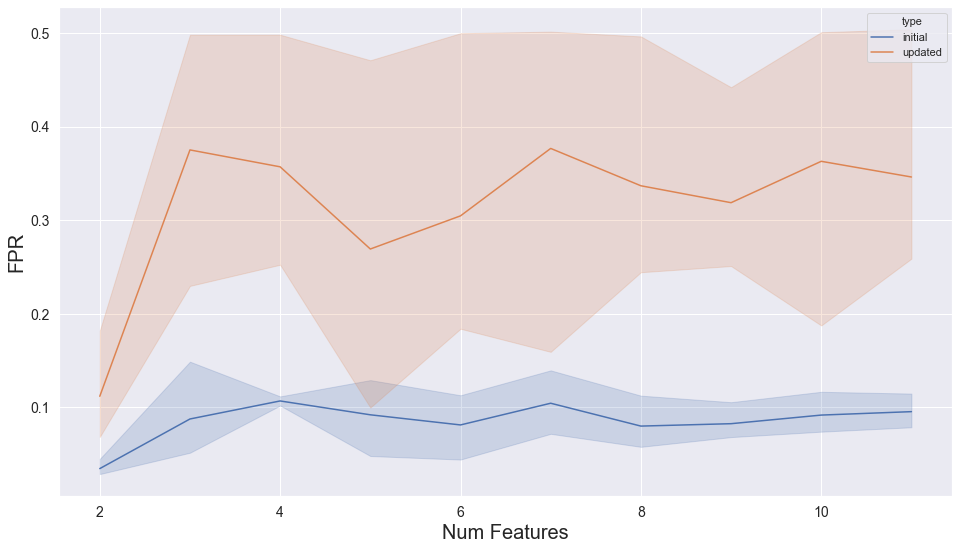

In [17]:
plot_name = "fpr_lineplot_num_features_{}".format(data_type)
plot_file_name = "{}_{}".format(plot_name, "")
plot_path = os.path.join(results_dir, plot_file_name)

create_file_path(plot_path)
plot(data_sklearn, plot_path)

config_file_name = CONFIG_FILE.format(plot_name, "")
config_path = os.path.join(results_dir, config_file_name)
save_json(config, config_path)

## Gaussian Data

In [18]:
m0 = -1
m1 = 1

s0 = 1
s1 = 1

p0 = 0.5
p1 = 1 - p0

In [19]:
n_train = 10000
n_update = 10000
n_test = 10000

temp_features = 10
features = np.arange(temp_features) + 2
num_updates = 100
seeds = 3

data_fn = generate_gaussian_dataset(m0, m1, s0, s1, p0, p1)
data_type = "gaussian"

In [20]:
initial_fprs_gaussian, updated_fprs_gaussian = train_update_loop(n_train, n_update, n_test, num_updates, features, data_fn, seeds)

In [21]:
data_gaussian = results_to_dataframe(initial_fprs_gaussian, updated_fprs_gaussian, features)

In [22]:
config = {"n_train": n_train, "n_update": n_update, "n_test": n_test, "features": temp_features, 
          "num_updates": num_updates, "seeds": seeds, "data_type": data_type, "m0": m0, "m1": m1,
         "s0": s0, "s1": s1, "p0": p0, "p1": p1}

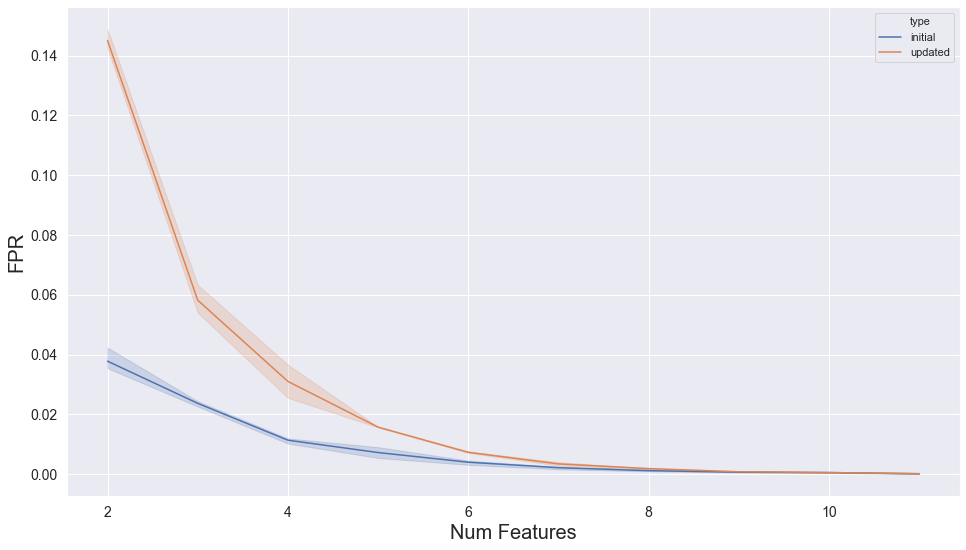

In [23]:
plot_name = "fpr_lineplot_num_features_{}".format(data_type)
plot_file_name = "{}_{}".format(plot_name, "")
plot_path = os.path.join(results_dir, plot_file_name)

create_file_path(plot_path)
plot(data_gaussian, plot_path)

config_file_name = CONFIG_FILE.format(plot_name, "")
config_path = os.path.join(results_dir, config_file_name)
save_json(config, config_path)